# Introduction to machine learning & Data Analysis

Basic introduction on how to perform typical machine learning tasks with Python.

Prepared by Mykhailo Vladymyrov & Aris Marcolongo,
Science IT Support, University Of Bern, 2021

This work is licensed under <a href="https://creativecommons.org/share-your-work/public-domain/cc0/">CC0</a>.

# Part 4.

# 0. Load libraries

In [3]:
from matplotlib import  pyplot as plt
import numpy as np
from imageio import imread
import pandas as pd
from time import time as timer

import tensorflow as tf

%matplotlib inline
from PIL import Image
from matplotlib import animation
from matplotlib import cm
from IPython.display import HTML


plt.rcParams["animation.html"] = "jshtml"  # for matplotlib 2.1 and above, uses JavaScript

# 1. Neural Networks Introduction

## 1. Perceptron

(Artificial) Neural network consists of layers of neurons. Artificial neuron, or perceptron, is in fact inspired by a biological neuron.

<img src="https://github.com/neworldemancer/DSF5/raw/master/figures/Perceptron.png" alt="drawing" width="30%"/>

Such neuron first calculates the linear transformation of the input vector $\bar x$: 
$$z = \bar W \cdot \bar x + b = \sum {W_i x_i} + b$$ where $\bar W$ is vector of weights and $b$ - bias.



This is effectively linear regression. You can combine those parallely to make a multidimensional prediction, e.g.:

<img src="https://github.com/neworldemancer/DSF5/raw/master/figures/2Perceptrons.png" alt="drawing" width="30%"/>

## 2. Nonlinearity

Combining multiple such objects performing linear transformation sequentially would not bring any additional benefit, as the combined output would still be a linear combination of the inputs.

What gives actual power to neurons, is that they additionally perform the nonlinear transformation of the result using activation function $f$ $$y = f(z)$$

The most commonly used non-linear transformations are:

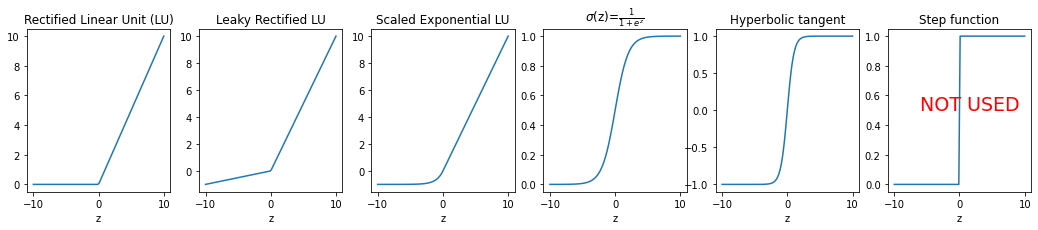

In [4]:
def ReLU(z):
  return np.clip(z, a_min=0, a_max=np.max(z))
def SELU(z, a=1):
  p = np.clip(z, a_min=0, a_max=np.max(z))
  n = np.clip(z, a_min=np.min(z), a_max=0)
  return p + (np.exp(n)-1) * a
def LReLU(z, a=0.1):
  return np.clip(z, a_min=0, a_max=np.max(z)) + np.clip(z, a_min=np.min(z), a_max=0) * a
def sigmoid(z):
  return 1/(1 + np.exp(-z)) 
def step(z):
  return np.heaviside(z, 0)
fig, ax = plt.subplots(1, 6, figsize=(18, 3))
z = np.linspace(-10, 10, 100)
ax[0].plot(z, ReLU(z))
ax[0].set_title('Rectified Linear Unit (LU)')
ax[1].plot(z, LReLU(z))
ax[1].set_title('Leaky Rectified LU')
ax[2].plot(z, SELU(z))
ax[2].set_title('Scaled Exponential LU')
ax[3].plot(z, sigmoid(z))
ax[3].set_title(r'$\sigma$(z)=$\frac{1}{1+e^z}$')
ax[4].plot(z, np.tanh(z))
ax[4].set_title('Hyperbolic tangent');
ax[5].plot(z, step(z))
ax[5].text(-6, 0.5, 'NOT USED', size=19, c='r')
ax[5].set_title('Step function');
for axi in ax:
  axi.set_xlabel('z')
plt.show()

And the reason we don't use a simple step function, is that it's everywhere either not differentiable or its derivative is zero.

The last nonlinearity to mention here is *softmax*:
$$y_i = SoftMax(\bar z)_i = \frac{ e^{z_i}}{\sum_j e^{z_j}}$$

While each $z_i$ can have any value, the corresponding $y_i\in[0,1]$, and $\sum_i y_i=1$, just like probabilities! 

While these $y_i$ are only pseudo-probabilities, this nonlinearity allows one to model probabilities, e.g. of a data-point belonging to a certain class.






## 3. Fully connected net

In a fully connected neural network each layer is a set of N neurons, performing different transformations of all the same layer's inputs $\bar x = [x_i]$ producing output vector $\bar y = [y_j]_{i=1..N}$: $$y_j = f(\bar W_j \cdot \bar x + b_j)$$

Since output of each layer forms input of next layer, one can write for layer $l$ (upper index denotes layer): $$x^l_j = f(\bar W^l_j \cdot \bar x^{l-1} + b^l_j)$$ where $\bar x^0$ is network's input vector.

<img src="https://github.com/neworldemancer/DSF5/raw/master/figures/MLP.png" alt="drawing" width="50%"/>


## 4. Loss function

The last part of the puzzle is the measure of network performance, which is used to optimize the network's parameters $W^l_j$ and $b^l_j$.
Denoting the network's output for an input $x_i$ as $\hat y_i=\hat y_i(x_i)$ and given the label $y_i$:

1. In case of regression loss shows "distance" from target values:
* L2 (MSE): $L = \sum_i (y_i-\hat y_i)^2$
* L1 (MAE): $L = \sum_i |y_i-\hat y_i|$

1. In case of classification we can use cross-entropy, which shows "distance" from target distribution:
$$L = - \sum_i \sum_c y_{i,c} \log(\hat y_{i,c})$$
Here $\hat y_{i,c}$ - pseudo-probability of $x_i$ belonging to class $c$ and $y_{i,c}$ uses 1-hot encoding:

$$y_{i,c}= 
\begin{cases}
    1,& \text{if } x_i \text{ belongs to class } c\\
    0,              & \text{otherwise}
\end{cases}$$


## 5. Training

Training of neural networks is performed iteratively. The weights  $W^l_j$ and $b^l_j$ are updated on each iteration of training according to the value of the derivative of the loss function with respect to corresponding parameter:
$$W^l_j \rightarrow W^l_j - \lambda \frac{\partial L}{\partial W^l_j }$$
$$b^l_j \rightarrow b^l_j - \lambda \frac{\partial L}{\partial b^l_j },$$

This is Gradient Descent optimization with learning rate $\lambda$. The partial derivatives are calculated by the chain law, and this approach is known as [backpropagation](https://en.wikipedia.org/wiki/Backpropagation).

In practice often for each iteration the loss $L$ is evaluated not on all samples, but on a sub-sample, so-called *minibatch* (sometimes - just batch). In most cases the sample order and selection for each minibatch is performed at random rendering this approach to be stochastic (thus it's called [Stochastic Gradient Descent](https://en.wikipedia.org/wiki/Stochastic_gradient_descent)). One iteration through all training data in minibatches is called *epoch*.

# 2. Regression with neural network

Here we will build a neural network to perform regression in 2D: we will fit $(x,y)$ pixel coordinates of an image to the pixel brightness at that location.

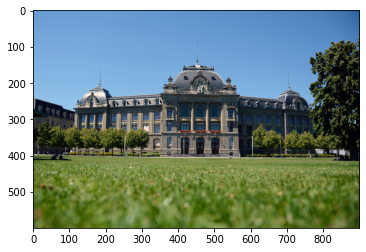

In [5]:
url = 'https://github.com/neworldemancer/DSF5/raw/master/figures/unibe.jpg'
image_big = imread(url)
image_big = image_big[...,0:3]/255
plt.imshow(image_big)
plt.show()

In [6]:
def subsample(im, factor):
  h, w = im.shape[:2]
  h = int(h/factor)
  w = int(w/factor)

  img = Image.fromarray((im*255).astype('uint8'))
  newimg = img.resize((w, h), Image.ANTIALIAS)
  return np.asarray(newimg)/255

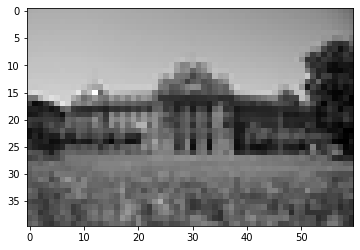

In [7]:
image = subsample(image_big, 15)
image = image.mean(axis=2, keepdims=True)
plt.imshow(image[...,0], cmap='gray')
plt.show()

In [8]:
h, w, c = image.shape

In [9]:
X0 = np.meshgrid(np.linspace(0, 1, w), np.linspace(0, 1, h))
X = np.stack(X0, axis=-1).reshape((-1, 2))

Y = image.reshape((-1, c))
X.shape, Y.shape

((2400, 2), (2400, 1))

In [10]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(2,)),
  tf.keras.layers.Dense(c, activation='sigmoid'),
])
model.compile(optimizer='adam',
              loss='mae',
              metrics=['mse'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 2)                 0         
_________________________________________________________________
dense (Dense)                (None, 1)                 3         
Total params: 3
Trainable params: 3
Non-trainable params: 0
_________________________________________________________________


In [11]:
hist = model.fit(X, Y, epochs=500, batch_size=2048)

Epoch 1/500
2/2 [==============================] - 1s 5ms/step - loss: 0.1852 - mse: 0.0507
Epoch 2/500
2/2 [==============================] - 0s 2ms/step - loss: 0.1847 - mse: 0.0504
Epoch 3/500
2/2 [==============================] - 0s 4ms/step - loss: 0.1842 - mse: 0.0501
Epoch 4/500
2/2 [==============================] - 0s 4ms/step - loss: 0.1837 - mse: 0.0498
Epoch 5/500
2/2 [==============================] - 0s 4ms/step - loss: 0.1832 - mse: 0.0496
Epoch 6/500
2/2 [==============================] - 0s 6ms/step - loss: 0.1827 - mse: 0.0493
Epoch 7/500
2/2 [==============================] - 0s 4ms/step - loss: 0.1823 - mse: 0.0491
Epoch 8/500
2/2 [==============================] - 0s 9ms/step - loss: 0.1818 - mse: 0.0488
Epoch 9/500
2/2 [==============================] - 0s 3ms/step - loss: 0.1813 - mse: 0.0485
Epoch 10/500
2/2 [==============================] - 0s 5ms/step - loss: 0.1808 - mse: 0.0483
Epoch 11/500
2/2 [==============================] - 0s 4ms/step - loss: 0.1803 

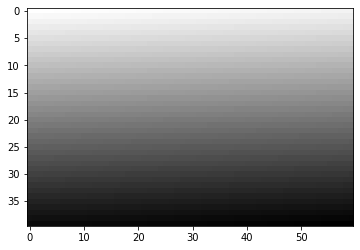

In [12]:
Y_p = model.predict(X)
Y_p = Y_p.reshape((h,w,c))
im = plt.imshow(Y_p[...,0], cmap='gray')
plt.show()

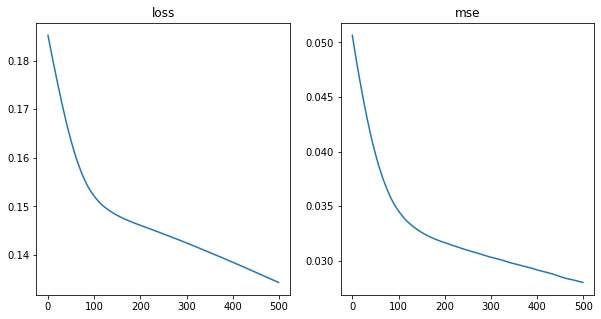

In [13]:
fig, axs = plt.subplots(1, 2, figsize=(10,5))
axs[0].plot(hist.epoch, hist.history['loss'])
axs[0].set_title('loss')
axs[1].plot(hist.epoch, hist.history['mse'])
axs[1].set_title('mse')
plt.show()

What is actually happening here? We fit an image with an $\mathbb{R}^2 \rightarrow \mathbb{R}$ funcion.

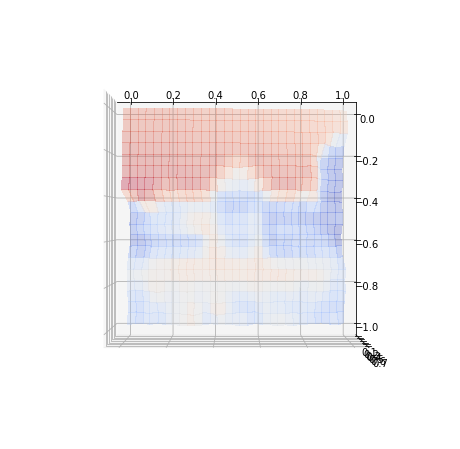

In [14]:
fig = plt.figure(figsize=(8,8))
ax = fig.gca(projection='3d')
ax.view_init(elev=90., azim=-90)  # azim=-50, elev=30

x = X[:,0].reshape((h,w))
y = X[:,1].reshape((h,w))
z = Y.reshape((h,w))
zp = Y_p.reshape((h,w))

ds = 2
x = subsample(x, ds)
y =-subsample(y, ds)
z = subsample(z, ds)
zp = subsample(zp, ds)

surf = ax.plot_surface(x,y,z, cmap='coolwarm', linewidth=0, antialiased=False, alpha=0.3)
#surf = ax.plot_surface(x,y,zp, cmap='coolwarm', linewidth=0, antialiased=False, alpha=0.5)
plt.show()

Let's try the same with an RGB image:

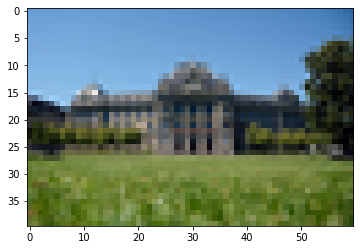

In [15]:
image = subsample(image_big, 15)
plt.imshow(image)
plt.show()

In [16]:
h, w, c = image.shape
X = np.meshgrid(np.linspace(0, 1, w), np.linspace(0, 1, h))
X = np.stack(X, axis=-1).reshape((-1, 2))

Y = image.reshape((-1, c))
X.shape, Y.shape

((2400, 2), (2400, 3))

In [17]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(2,)),
  tf.keras.layers.Dense(c, activation='sigmoid'),
])
model.compile(optimizer='adam',
              loss='mae',
              metrics=['mse'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 2)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 9         
Total params: 9
Trainable params: 9
Non-trainable params: 0
_________________________________________________________________


But now we will save images during the course of training, at first after 2, then 4, 8, 16, etc epochs.
(**Remember**: call to `model.fit` does NOT reinitialize trainable variables. Every time it continues from the previous state):

To be  trained for total number of epochs:2048
epoch 0
epoch 200
epoch 400
epoch 600
epoch 800
epoch 1000
epoch 1200
epoch 1400
epoch 1600
epoch 1800
epoch 2000


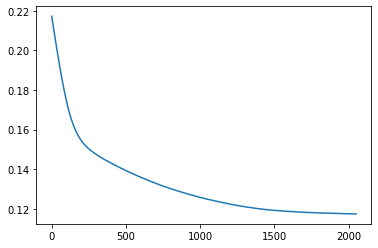

In [18]:
ims = []
loss_hist = []
n_ep_pow = 11
save_epochs = [0]+[2**i for i in range(n_ep_pow)]
n_ep_tot = save_epochs[-1]

ne = 2
print(f'To be  trained for total number of epochs:{n_ep_tot*ne}')

for i in range(n_ep_tot+1):
  if i % 100 == 0:
    print(f'epoch {i*ne}', end='\n')
  hist = model.fit(X, Y, epochs=ne, batch_size=1*2048, verbose=0)
  loss_hist += hist.history['loss']

  if i in save_epochs:
    Y_p = model.predict(X)
    Y_p = Y_p.reshape((h, w, c))
    ims.append(Y_p)

plt.plot(loss_hist)
plt.show()

In [19]:
%%capture

fig = plt.figure()
im = plt.imshow(ims[0])

def animate(i):
    img = ims[i]
    im.set_data(img)
    return im

ani = animation.FuncAnimation(fig, animate, frames=len(ims))

In [20]:
ani

While the colors properly represent the target image, our model still poses very limited capacity, allowing it to effectively represent only 3 boundaries.

Let's upscale our model:

In [21]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(2,)),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(8, activation='relu'),
  tf.keras.layers.Dense(c, activation='sigmoid'),
])
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.005), # optimizer='adam',
              loss='mae',
              metrics=['mse'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 2)                 0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               384       
_________________________________________________________________
dense_3 (Dense)              (None, 8)                 1032      
_________________________________________________________________
dense_4 (Dense)              (None, 3)                 27        
Total params: 1,443
Trainable params: 1,443
Non-trainable params: 0
_________________________________________________________________


total number of epochs trained:8192
epoch 0
epoch 200
epoch 400
epoch 600
epoch 800
epoch 1000
epoch 1200
epoch 1400
epoch 1600
epoch 1800
epoch 2000
epoch 2200
epoch 2400
epoch 2600
epoch 2800
epoch 3000
epoch 3200
epoch 3400
epoch 3600
epoch 3800
epoch 4000
epoch 4200
epoch 4400
epoch 4600
epoch 4800
epoch 5000
epoch 5200
epoch 5400
epoch 5600
epoch 5800
epoch 6000
epoch 6200
epoch 6400
epoch 6600
epoch 6800
epoch 7000
epoch 7200
epoch 7400
epoch 7600
epoch 7800
epoch 8000


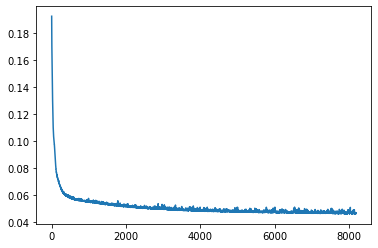

In [22]:
ims = []
loss_hist = []
n_ep_pow = 13
save_epochs = [0]+[2**i for i in range(n_ep_pow)]
n_ep_tot = save_epochs[-1]

ne = 2
print(f'total number of epochs trained:{n_ep_tot*ne}')

for i in range(n_ep_tot+1):
  if i % 100 == 0:
    print(f'epoch {i*ne}', end='\n')
  hist = model.fit(X, Y, epochs=ne, batch_size=1*2048, verbose=0)
  loss_hist += hist.history['loss']

  if i in save_epochs:
    Y_p = model.predict(X)
    Y_p = Y_p.reshape((h, w, c))
    ims.append(Y_p)

plt.plot(loss_hist)
plt.show()

In [23]:
%%capture
fig = plt.figure()
im = plt.imshow(ims[0])

def animate(i):
    img = ims[i]
    im.set_data(img)
    return im

ani = animation.FuncAnimation(fig, animate, frames=len(ims))

In [24]:
ani

We can also now render the fitted image at any resolution, by evaluating values in between of the original pixels:

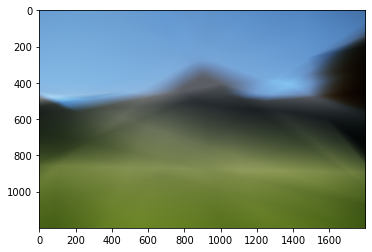

In [25]:
scale = 30
w_rend = w * scale
h_rend = h * scale
X_rend = np.meshgrid(np.linspace(0, 1, w_rend), np.linspace(0, 1, h_rend))
X_rend = np.stack(X_rend, axis=-1).reshape((-1, 2))

Y_rend = model.predict(X_rend)
Y_rend = Y_rend.reshape((h_rend, w_rend, c))

plt.imshow(Y_rend)

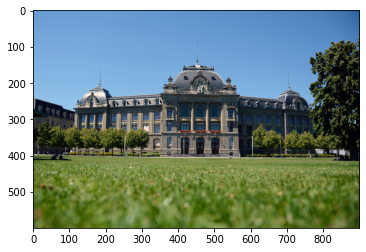

In [26]:
plt.imshow(image_big)

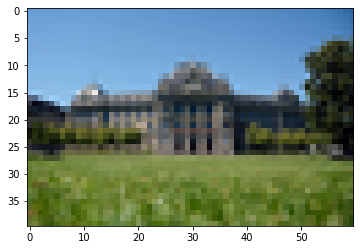

In [27]:
plt.imshow(image)

## EXERCISE 4. Regression on an image with Neural Network.

Load some image, downscale to a similar resolution, and train a deeper model, for example 5 layers, more parameters in widest layers.

In [28]:
# 1. Load your image

# 2. build a deeper model

# 3. inspect the evolution

# 3. Classification of the F-MNIST dataset with neural network

## 0. Load data

We will create a model for classification of the F-MNIST dataset that we go acquainted with in previous sessions. We will normalize the inputs to have values $\in[0,1]$:

In [29]:
fashion_mnist = tf.keras.datasets.fashion_mnist
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
x_train = x_train/255
x_test = x_test/255

class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

4431872/4422102 [==============================] - 0s 0us/step


## 1. Building a neural network

In [30]:
print(x_train[0].shape)

(28, 28)


The size of each image sample $-\; 28\times28\text{ pixels}\;-\;$ defines the input size for our neural network. Network's output - probabilities of belonging to each of the 10 classes.

The following creates a 'model'. It is an object containing the neural network model itself - a simple 3-layer fully connected neural network, optimization parameters, as well as the interface for model training.

In [31]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),
  tf.keras.layers.Dense(10, activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

Model summary provides information about the model's layers and trainable parameters

In [32]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_3 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 10)                7850      
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
_________________________________________________________________


## 2. Model training

The `fit` function is the interface for model training. 
Here one can specify training and validation datasets, minibatch size, and the number of training epochs.

Here during training we also save the trained models checkpoints after each epoch of training.

In [33]:
save_path = 'save/mnist_{epoch}.ckpt'
save_callback = tf.keras.callbacks.ModelCheckpoint(filepath=save_path, save_weights_only=True)

hist = model.fit(x=x_train, y=y_train,
                 epochs=50, batch_size=128, 
                 validation_data=(x_test, y_test),
                 callbacks=[save_callback])

Epoch 1/50
469/469 [==============================] - 1s 2ms/step - loss: 0.7494 - accuracy: 0.7536 - val_loss: 0.5751 - val_accuracy: 0.8045
Epoch 2/50
469/469 [==============================] - 1s 2ms/step - loss: 0.5160 - accuracy: 0.8275 - val_loss: 0.5137 - val_accuracy: 0.8238
Epoch 3/50
469/469 [==============================] - 1s 2ms/step - loss: 0.4749 - accuracy: 0.8395 - val_loss: 0.4982 - val_accuracy: 0.8281
Epoch 4/50
469/469 [==============================] - 1s 2ms/step - loss: 0.4522 - accuracy: 0.8470 - val_loss: 0.4781 - val_accuracy: 0.8371
Epoch 5/50
469/469 [==============================] - 1s 2ms/step - loss: 0.4388 - accuracy: 0.8507 - val_loss: 0.4649 - val_accuracy: 0.8390
Epoch 6/50
469/469 [==============================] - 1s 2ms/step - loss: 0.4280 - accuracy: 0.8543 - val_loss: 0.4629 - val_accuracy: 0.8388
Epoch 7/50
469/469 [==============================] - 1s 2ms/step - loss: 0.4207 - accuracy: 0.8557 - val_loss: 0.4572 - val_accuracy: 0.8403
Epoch 

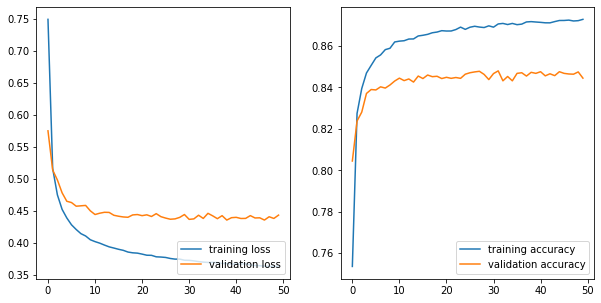

In [34]:
fig, axs = plt.subplots(1, 2, figsize=(10,5))
axs[0].plot(hist.epoch, hist.history['loss'])
axs[0].plot(hist.epoch, hist.history['val_loss'])
axs[0].legend(('training loss', 'validation loss'), loc='lower right')
axs[1].plot(hist.epoch, hist.history['accuracy'])
axs[1].plot(hist.epoch, hist.history['val_accuracy'])

axs[1].legend(('training accuracy', 'validation accuracy'), loc='lower right')
plt.show()

Current model performance can be evaluated, e.g. on the test dataset:

---



In [35]:
model.evaluate(x_test,  y_test, verbose=2)

313/313 - 0s - loss: 0.4432 - accuracy: 0.8445


[0.4432285726070404, 0.8445000052452087]

We can test trained model on an image:

true lablel:  9 ; predicted:  9 (Ankle boot)


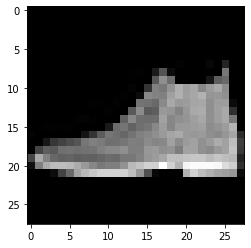

In [36]:
im_id = 0
y_pred = model(x_test)

y_pred_most_probable = np.argmax(y_pred[im_id])
print('true lablel: ', y_test[im_id],
      '; predicted: ',  y_pred_most_probable,
      f'({class_names[y_pred_most_probable]})')
plt.imshow(x_test[im_id], cmap='gray');

As well as inspect on which samples does the model fail:

true lablel:  7 (Sneaker) ; predicted:  5 (Sandal)


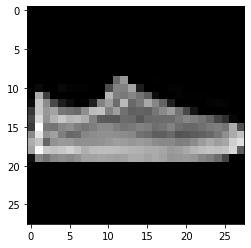

In [37]:
y_pred_most_probable_all = np.argmax(y_pred, axis=1)
wrong_pred_map = y_pred_most_probable_all!=y_test
wrong_pred_idx = np.arange(len(wrong_pred_map))[wrong_pred_map]

im_id = wrong_pred_idx[0]

y_pred_most_probable = y_pred_most_probable_all[im_id]
print('true lablel: ', y_test[im_id],
      f'({class_names[y_test[im_id]]})',
      '; predicted: ',  y_pred_most_probable,
      f'({class_names[y_pred_most_probable]})')
plt.imshow(x_test[im_id], cmap='gray');
plt.show()

## 3. Loading trained model

In [38]:
model.load_weights('save/mnist_1.ckpt')
model.evaluate(x_test,  y_test, verbose=2)

model.load_weights('save/mnist_12.ckpt')
model.evaluate(x_test,  y_test, verbose=2)

model.load_weights('save/mnist_18.ckpt')
model.evaluate(x_test,  y_test, verbose=2)

313/313 - 0s - loss: 0.5751 - accuracy: 0.8045
313/313 - 0s - loss: 0.4462 - accuracy: 0.8433
313/313 - 0s - loss: 0.4399 - accuracy: 0.8452


[0.4398665428161621, 0.8452000021934509]

## 4. Inspecting trained variables

We can obtain the trained variables from model layers:

In [39]:
l = model.get_layer(index=1)
w, b = l.weights

w = w.numpy()
b = b.numpy()
print(w.shape, b.shape)
w = w.reshape((28,28,-1)).transpose((2, 0, 1))

(784, 10) (10,)


Let's visualize first 10:

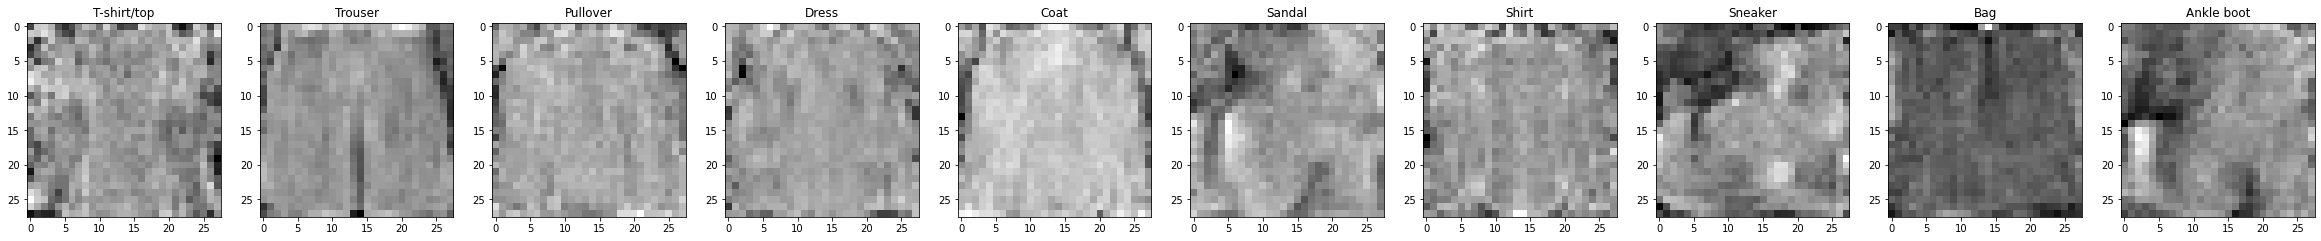

In [40]:
n = 10
fig, axs = plt.subplots(1, n, figsize=(4.1*n,4))
for i, wi in enumerate(w[:n]):
  axs[i].imshow(wi, cmap='gray')
  axs[i].set_title(class_names[i])
plt.show()

## 6. Inspecting gradients

We can also evaluate the gradients of each output with respect to an input:

In [41]:
idx = 112
inp_v = x_train[idx:idx+1]  # use some image to compute gradients with respect to

inp = tf.constant(inp_v)  # create tf constant tensor
with tf.GradientTape() as tape:  # gradient tape for gradint evaluation
  tape.watch(inp)  # take inp as variable
  preds = model(inp) # evaluate model output

grads = tape.jacobian(preds, inp)  # evaluate d preds[i] / d inp[j]
print(grads.shape, '<- (Batch_preds, preds[i], Batch_inp, inp[y], inp[x])')
grads = grads.numpy()[0,:,0]

(1, 10, 1, 28, 28) <- (Batch_preds, preds[i], Batch_inp, inp[y], inp[x])


prediction: 6


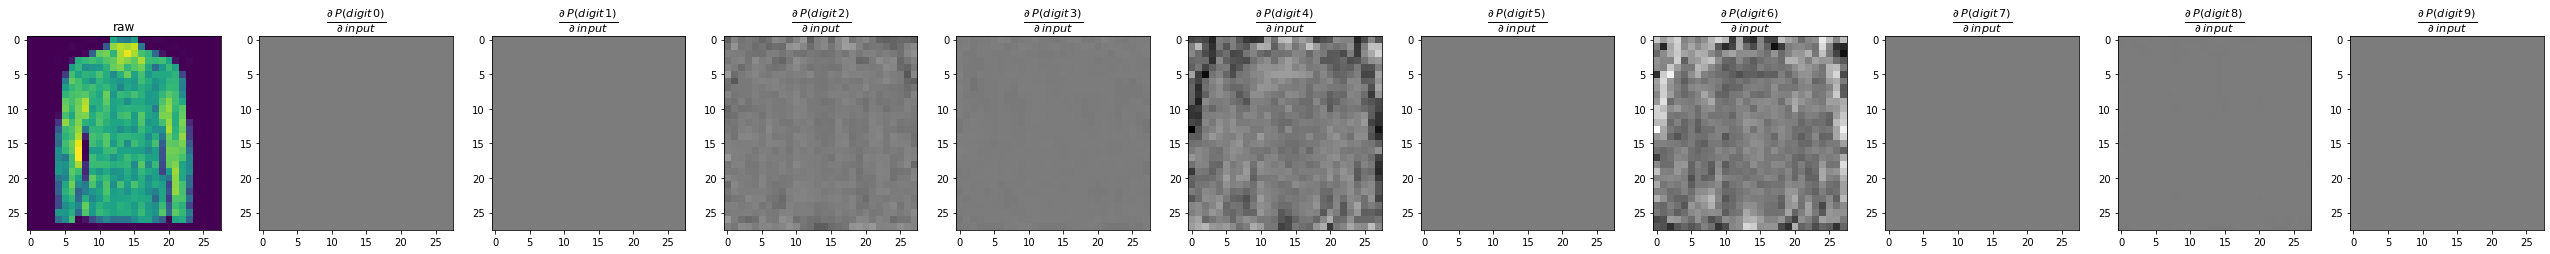

In [42]:
print('prediction:', np.argmax(preds[0]))
fig, axs = plt.subplots(1, 11, figsize=(4.1*11,4))
axs[0].imshow(inp_v[0])
axs[0].set_title('raw')
vmin,vmax = grads.min(), grads.max()
for i, g in enumerate(grads):
  axs[i+1].imshow(g, cmap='gray', vmin=vmin, vmax=vmax)
  axs[i+1].set_title(r'$\frac{\partial\;P(digit\,%d)}{\partial\;input}$' % i, fontdict={'size':16})
plt.show()

## EXERCISE 1: Train deeper network for F-MNIST classification

Make a deeper model, with wider layers. Remember to use the `'softmax'` activation in the last layer, as required for the classification task to encode pseudoprobabilities. In the other layers you could use `'relu'`.

Try to achieve 90% accuracy.
Does your model overfit?

In [62]:
# 1. create model
model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),
  tf.keras.layers.Dense(20, activation='relu'),
  tf.keras.layers.Dense(20, activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])




# 4. evaluate model in best point (before overfitting)

In [63]:
# 2. train the model
save_path = 'save/mnist_{epoch}.ckpt'
save_callback = tf.keras.callbacks.ModelCheckpoint(filepath=save_path, save_weights_only=True)

hist = model.fit(x=x_train, y=y_train,
                 epochs=50, batch_size=128, 
                 validation_data=(x_test, y_test),
                 callbacks=[save_callback])

Epoch 1/50
469/469 [==============================] - 2s 3ms/step - loss: 0.8060 - accuracy: 0.7318 - val_loss: 0.5544 - val_accuracy: 0.8137
Epoch 2/50
469/469 [==============================] - 1s 3ms/step - loss: 0.4976 - accuracy: 0.8310 - val_loss: 0.4923 - val_accuracy: 0.8311
Epoch 3/50
469/469 [==============================] - 1s 3ms/step - loss: 0.4543 - accuracy: 0.8437 - val_loss: 0.4735 - val_accuracy: 0.8336
Epoch 4/50
469/469 [==============================] - 1s 3ms/step - loss: 0.4320 - accuracy: 0.8504 - val_loss: 0.4688 - val_accuracy: 0.8339
Epoch 5/50
469/469 [==============================] - 1s 3ms/step - loss: 0.4174 - accuracy: 0.8543 - val_loss: 0.4628 - val_accuracy: 0.8395
Epoch 6/50
469/469 [==============================] - 1s 3ms/step - loss: 0.4080 - accuracy: 0.8575 - val_loss: 0.4406 - val_accuracy: 0.8434
Epoch 7/50
469/469 [==============================] - 1s 3ms/step - loss: 0.3978 - accuracy: 0.8612 - val_loss: 0.4364 - val_accuracy: 0.8461
Epoch 

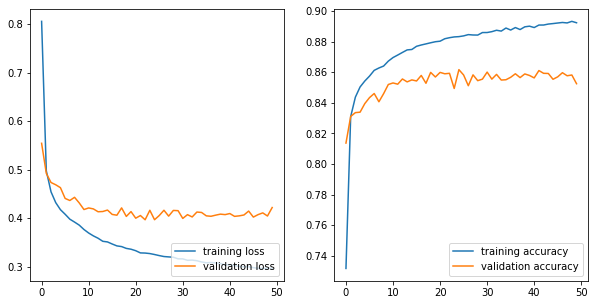

In [64]:
# 3. plot the loss and accuracy evolution during training
fig, axs = plt.subplots(1, 2, figsize=(10,5))
axs[0].plot(hist.epoch, hist.history['loss'])
axs[0].plot(hist.epoch, hist.history['val_loss'])
axs[0].legend(('training loss', 'validation loss'), loc='lower right')
axs[1].plot(hist.epoch, hist.history['accuracy'])
axs[1].plot(hist.epoch, hist.history['val_accuracy'])

axs[1].legend(('training accuracy', 'validation accuracy'), loc='lower right')
plt.show()

# 4. Extras and Q&A

<img src="https://github.com/neworldemancer/DSF5/raw/master/figures/cheatsheet.png" width="100%"/>

<img src="https://github.com/neworldemancer/DSF5/raw/master/figures/clusters.png" width="100%"/>